# LOAD DATA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

c:\Users\andre\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
character = pd.read_csv('./data/MovieSummaries/character.metadata.tsv', sep='\t', header=None)
movie = pd.read_csv('./data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv('./data/MovieSummaries/plot_summaries.txt', sep='\t', header=None)
IMDb_data = pd.read_csv('./data/IMDb/akas.tsv', sep='\t', dtype={7: str})
IMDb_ratings = pd.read_csv('./data/IMDb/ratings.tsv', sep='\t')
TheMoviesDataset = pd.read_csv('./data/TheMoviesDataset/movies_metadata.csv')
mojo_int1000 = pd.read_csv('./data/Mojo/boxofficemojointernationaltop1000.tsv', sep='\t')
mojo_us1000 = pd.read_csv('./data/Mojo/boxofficemojoustop1000.tsv', sep='\t')
inflation = pd.read_excel('./data/Inflation/Inflation-data.xlsx', sheet_name='hcpi_a')

C:\Users\andre\AppData\Local\Temp\ipykernel_17588\1262017686.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  TheMoviesDataset = pd.read_csv('./data/TheMoviesDataset/movies_metadata.csv')


In [ ]:
# Adding column names
movie_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie name", "Movie release date", "Movie box office revenue", "Movie runtime", "Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)"]
character_columns = ["Wikipedia movie ID", "Freebase movie ID", "Movie release date", "Character name", "Actor date of birth", "Actor gender", "Actor height (in meters)", "Actor ethnicity (Freebase ID)", "Actor name", "Actor age at movie release", "Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"]
plot_summaries_columns = ["Wikipedia movie ID", "Plot summary"]
movie.columns = movie_columns
character.columns = character_columns
plot_summaries.columns = plot_summaries_columns

In [4]:
## PREPARE INFLATION DF

# Considering inflation in the US as a baseline
inflation_us = inflation[inflation['Country Code']=='USA']

# Melt the DataFrame to reshape it
melted_inflation = pd.melt(inflation_us, id_vars=['Country Code', 'IMF Country Code', 'Country', 'Indicator Type', 'Series Name'], var_name='Year', value_name='Inflation')

# Convert the "Year" column to numeric
melted_inflation['Year'] = pd.to_numeric(melted_inflation['Year'], errors='coerce')

melted_inflation = melted_inflation[['Year','Inflation']]

melted_inflation = melted_inflation.iloc[:-2]

# Create a DataFrame with years from 1914 to 1969 and 'inflation' set to 0
additional_years = pd.DataFrame({'Year': range(1914, 1970), 'Inflation': 0})

# Merge the additional_years DataFrame with melted_inflation (Adding 0 inflation to missing years)
melted_inflation = pd.concat([melted_inflation, additional_years], ignore_index=True, sort=False)

# Sort the DataFrame
melted_inflation = melted_inflation.sort_values(by='Year')

# Calculate cumulative inflation to adapt revenues further
melted_inflation['Cumulative Inflation'] = (melted_inflation['Inflation'].astype(float)/100 + 1).cumprod()

display(melted_inflation)

,Year,Inflation,Cumulative Inflation
53,1914.0,0,1.000000
54,1915.0,0,1.000000
55,1916.0,0,1.000000
56,1917.0,0,1.000000
57,1918.0,0,1.000000
...,...,...,...
48,2018.0,2.44,6.849168
49,2019.0,1.812,6.973275
50,2020.0,1.233584,7.059296
51,2021.0,4.697859,7.390932


In [55]:
# Merging movies, actors and ratings
movie_actor = pd.merge(movie, character, how="left", on=["Wikipedia movie ID","Freebase movie ID"])
IMDb_combined = pd.merge(IMDb_data,IMDb_ratings,left_on='titleId',right_on='tconst')
IMDb_combined_mean = IMDb_combined[['title','averageRating']].groupby(['title']).mean()
IMDb_combined_mean.reset_index(inplace=True)
actor_detail_rating = pd.merge(movie_actor,IMDb_combined_mean[['title','averageRating']],left_on='Movie name',right_on='title')

In [56]:
# ADD MISSING BOX OFFICE & RELEASE DATE FROM OTHER DATASETS (Mojo & The Movies Dataset)
# # Date of birth/Gender/Ethnicity (Gender can be determined from name)

# Define a list of datasets to merge
datasets = [
    (TheMoviesDataset, 'original_title', 'revenue','release_date'),
    (mojo_us1000, 'Movie', 'Lifetime Gross','Year'),
    (mojo_int1000, 'Title', 'Worldwide Lifetime Gross','Year')
]

# Remove rows that have revenue = 0
TheMoviesDataset=TheMoviesDataset[TheMoviesDataset['revenue']!=0.0]


# Iterate through the datasets and merge
for dataset, movie_column, revenue_column, date_column in datasets:
    actor_detail_rating = pd.merge(actor_detail_rating, dataset[[movie_column, revenue_column, date_column]], left_on='Movie name', right_on=movie_column, how='left')
    actor_detail_rating['Movie box office revenue'] = actor_detail_rating['Movie box office revenue'].fillna(actor_detail_rating[revenue_column])
    actor_detail_rating['Movie release date_x'] = actor_detail_rating['Movie release date_x'].fillna(actor_detail_rating[date_column])
    actor_detail_rating = actor_detail_rating.drop([revenue_column,date_column], axis=1)
    # print(actor_detail_rating['Movie box office revenue'].isna().sum())



In [57]:
# Handle Nan Values 
# Convert Nans to 0
actor_detail_rating['Movie box office revenue'] = actor_detail_rating['Movie box office revenue'].fillna(0)
# # Remove rows with Box office = Nan
# actor_detail_rating.dropna(subset='Movie box office revenue', inplace=True)

In [58]:
# ADAPT BOX OFFICE REVENUE WITH INFLATION
actor_detail_rating['Year'] = actor_detail_rating['Movie release date_x'].str.extract(r'(\d{4})').astype(float)
actor_detail_rating_inflation = pd.merge(actor_detail_rating,melted_inflation[['Year','Cumulative Inflation']])

actor_detail_rating_inflation['Adapted Movie box office revenue'] = actor_detail_rating_inflation['Movie box office revenue']/actor_detail_rating_inflation['Cumulative Inflation']
display(actor_detail_rating_inflation)

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date_x,Movie box office revenue,Movie runtime,Movie languages (Freebase ID:name tuples),Movie countries (Freebase ID:name tuples),Movie genres (Freebase ID:name tuples),Movie release date_y,...,Freebase character ID,Freebase actor ID,title,averageRating,original_title,Movie,Title,Year,Cumulative Inflation,Adapted Movie box office revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgchn4,/m/0346l4,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgchn_,/m/01vw26l,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgchnq,/m/034hyc,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001-08-24,...,/m/0bgchp9,/m/01y9xg,Ghosts of Mars,4.900000,Ghosts of Mars,NaN,NaN,2001.0,4.829498,2.901095e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410604,33055356,/m/0h5293g,The Other Woman,2014-04-16,196781193.0,NaN,{},{},"{""/m/02xh1"": ""Film noir""}",NaN,...,NaN,/m/05p10m,The Other Woman,6.713253,The Other Woman,The Other Woman,The Other Woman,2014.0,6.456986,3.047571e+07
410605,33055356,/m/0h5293g,The Other Woman,2014-04-16,196781193.0,NaN,{},{},"{""/m/02xh1"": ""Film noir""}",NaN,...,NaN,/m/02x6_7q,The Other Woman,6.713253,The Other Woman,The Other Woman,The Other Woman,2014.0,6.456986,3.047571e+07
410606,33055356,/m/0h5293g,The Other Woman,2014-04-16,196781193.0,NaN,{},{},"{""/m/02xh1"": ""Film noir""}",NaN,...,NaN,/m/07z586,The Other Woman,6.713253,The Other Woman,The Other Woman,The Other Woman,2014.0,6.456986,3.047571e+07
410607,36351451,/m/0k3p3fy,The Elder,2014,0.0,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03k9fj"": ""Adventure""}",NaN,...,NaN,NaN,The Elder,7.800000,NaN,NaN,NaN,2014.0,6.456986,0.000000e+00


# FAME

In [59]:
# Conserve relevant columns
columns_to_conserve = ['Actor name', 'Movie name', 'Movie release date_y', 'averageRating', 'Adapted Movie box office revenue']
conserved_df = actor_detail_rating_inflation[columns_to_conserve].copy()
conserved_df['Year'] = conserved_df['Movie release date_y'].str.extract('(\d{4})')
conserved_df.columns = ['Actor Name', 'Movie name', 'Date', 'Rating', 'Revenue', 'Year']
conserved_df = conserved_df.groupby(['Actor Name', 'Movie name', 'Year'], as_index=False).agg({
    'Rating': 'mean',
    'Revenue': 'mean'
})

conserved_df = conserved_df.sort_values(by='Year', ascending=False)

display(conserved_df)

,Actor Name,Movie name,Year,Rating,Revenue
301583,Ray Wise,Jeepers Creepers 4,2016,2.500000,0.0
225819,Luke Edwards,Jeepers Creepers 4,2016,2.500000,0.0
235908,Marieh Delfino,Jeepers Creepers 4,2016,2.500000,0.0
125935,Gina Philips,Jeepers Creepers 4,2016,2.500000,0.0
184009,Jonathan Breck,Jeepers Creepers 4,2016,2.500000,0.0
...,...,...,...,...,...
139292,Henry Lehrman,Mabel's Busy Day,1914,5.400000,0.0
139291,Henry Lehrman,Kid Auto Races at Venice,1914,5.700000,0.0
311632,Robert Cummings,The Jungle,1914,5.921951,0.0
385842,Yale Boss,The Active Life of Dolly of the Dailies,1914,6.000000,0.0


In [60]:
## 0TH STEP: REMOVE ACTORS WHO HAVE LESS THAN 10 MOVIES IN THE DF
actor_movie_counts = conserved_df['Actor Name'].value_counts()
actors_with_10_or_more_movies = actor_movie_counts[actor_movie_counts >= 10].index
filtered_df = conserved_df[conserved_df['Actor Name'].isin(actors_with_10_or_more_movies)]

In [94]:
## 1ST STEP: RANKIZE RATING AND REVENUE
columns_to_scale = ['Revenue', 'Rating']
actor_popularity_rank = filtered_df.copy()
ranks = filtered_df[columns_to_scale].rank()
# normalized_ranks to be between 0 and 1
normalized_ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
actor_popularity_rank[columns_to_scale] = normalized_ranks
actor_popularity_rank = actor_popularity_rank.sort_values(by='Year', ascending=False)

display(actor_popularity_rank)

,Actor Name,Movie name,Year,Rating,Revenue
301583,Ray Wise,Jeepers Creepers 4,2016,0.001967,0.0
125935,Gina Philips,Jeepers Creepers 4,2016,0.001967,0.0
43103,Brandon Smith,Jeepers Creepers 4,2016,0.001967,0.0
225819,Luke Edwards,Jeepers Creepers 4,2016,0.001967,0.0
25393,Arshad Warsi,Total Dhamaal,2015,0.041014,0.0
...,...,...,...,...,...
57746,Charley Chase,"Hello, Mabel",1914,0.103481,0.0
57744,Charley Chase,Dough and Dynamite,1914,0.278634,0.0
134555,Harold Lloyd,The Patchwork Girl of Oz,1914,0.143333,0.0
57824,Charlie Chaplin,"Cruel, Cruel Love",1914,0.134526,0.0


In [95]:
## 2ND STEP: COMPUTE ACTOR FAME COEFFICIENT FOR A CERATAIN MOVIE IN A CERTAIN YEAR
columns_to_scale = ['Revenue', 'Rating']
weights = [4, 1]  # Adjust weights based on your preference
actor_popularity_movie_coef = actor_popularity_rank
# Calculate weighted average of normalized rating and normalized revenue
actor_popularity_movie_coef['Fame Coefficient'] = np.average(actor_popularity_rank[columns_to_scale], axis=1, weights=weights)

actor_popularity_movie_coef = actor_popularity_movie_coef.sort_values(by='Fame Coefficient',ascending=False)

display(actor_popularity_movie_coef)

,Actor Name,Movie name,Year,Rating,Revenue,Fame Coefficient
144490,Ian McKellen,The Lord of the Rings: The Return of the King,2003,0.998527,0.99704,0.997338
53445,Cate Blanchett,The Lord of the Rings: The Return of the King,2003,0.998527,0.99704,0.997338
144318,Ian Holm,The Lord of the Rings: The Return of the King,2003,0.998527,0.99704,0.997338
181019,John Rhys-Davies,The Lord of the Rings: The Return of the King,2003,0.998527,0.99704,0.997338
47020,Bruce Spence,The Lord of the Rings: The Return of the King,2003,0.998527,0.99704,0.997338
...,...,...,...,...,...,...
272492,Nirmal Pandey,Desh Drohi,2008,0.000035,0.00000,0.000007
204565,Kim Sharma,Desh Drohi,2008,0.000035,0.00000,0.000007
299983,Ranjeet,Desh Drohi,2008,0.000035,0.00000,0.000007
183965,Jonathan Banks,Proud American,2008,0.000005,0.00000,0.000001


In [96]:
### 3RD STEP: COMPUTE SUM OF ACTOR FAME COEFFICIENT FOR A CERTAIN YEAR (OVER THE MOVIES OF THIS YEAR)
actor_movie_year = actor_popularity_movie_coef.groupby(['Actor Name', 'Year'])['Fame Coefficient'].sum().reset_index()
actor_movie_year = actor_movie_year[actor_movie_year['Year'] >= '1914']
actor_movie_year['Year'] = actor_movie_year['Year'].replace('1010', '2010')

actor_movie_year = actor_movie_year.sort_values(by='Year',ascending=True)

display(actor_movie_year)

,Actor Name,Year,Fame Coefficient
32519,Ford Sterling,1914,0.061623
30355,Emma Dunn,1914,0.151823
41341,Horace B. Carpenter,1914,0.011224
74925,Milton Berle,1914,0.074113
68436,Marie Dressler,1914,0.121533
...,...,...,...
99539,Sigourney Weaver,2015,0.188445
36910,Gina Philips,2016,0.000393
12117,Brandon Smith,2016,0.000393
87651,Ray Wise,2016,0.000393


In [97]:
## CHECKING FOR CORRECTNESS WITH Željko Ivanek IN 2012
zelko_ivanek_df = actor_popularity_movie_coef[(actor_popularity_movie_coef['Actor Name'] == 'Željko Ivanek') & (actor_popularity_movie_coef['Year'] == '2012')]
display(zelko_ivanek_df)

,Actor Name,Movie name,Year,Rating,Revenue,Fame Coefficient
391038,Željko Ivanek,Argo,2012,0.930487,0.817441,0.840050
391052,Željko Ivanek,Seven Psychopaths,2012,0.816181,0.636107,0.672122
391059,Željko Ivanek,The Words,2012,0.801091,0.631035,0.665046


In [98]:
## 4TH STEP: CREATE DATAFRAME WITH FAME COEFFICIENT FOR EACH ACTOR EACH YEAR
# Create a DataFrame with all actor-year combinations from 1914 to 2012
years = list(range(1914, 2013))
actors = actor_movie_year['Actor Name'].unique()
actor_year_combinations = pd.MultiIndex.from_product([actors, years], names=['Actor Name', 'Year']).to_frame(index=False)
actor_year_combinations.columns = ['Actor Name', 'Year']
actor_year_combinations['Year'] = actor_year_combinations['Year'].astype(str)

# Merge the actor_year_combinations DataFrame with actor_movie_year to get the coefficients
all_actor_year = pd.merge(actor_year_combinations, actor_movie_year, on=['Actor Name', 'Year'], how='left')

# Fill missing values in the 'Fame Coefficient' column with 0
all_actor_year['Fame Coefficient'].fillna(0, inplace=True)

# Rename 'Fame Coefficient' to 'Actor Year Coefficient'
all_actor_year.rename(columns={'Fame Coefficient': 'Fame Coefficient'}, inplace=True)

# Sort the result DataFrame
all_actor_year = all_actor_year.sort_values(by=['Year', 'Actor Name'], ascending=[True, True])

# Reset the index
all_actor_year.reset_index(drop=True, inplace=True)

display(all_actor_year)

,Actor Name,Year,Fame Coefficient
0,50 Cent,1914,0.000000
1,A Martinez,1914,0.000000
2,A. J. Buckley,1914,0.000000
3,A. J. Cook,1914,0.000000
4,A.K Hangal,1914,0.000000
...,...,...,...
819319,Zoë Kravitz,2012,0.000000
819320,Zsa Zsa Gábor,2012,0.000000
819321,Ángela Molina,2012,0.000000
819322,Édith Scob,2012,0.572140


In [99]:
## 5TH STEP: FOR FAME THROUGH YEARS: ADD A CONTRIBUTION OF THE FAME COEFFICIENT OF THE PREVIOUS YEARS
previous_year_contribution = 0.7

actor_year_df = all_actor_year.copy()
actor_year_df.sort_values(by=['Actor Name', 'Year'], inplace=True)

# Initialize a dictionary to store the previous 'Coefficient with Past' values for each actor
prev_b_values = {}

# Iterate through the rows of the DataFrame to compute the values for column B
for index, row in actor_year_df.iterrows():
    actor = row['Actor Name']
    year = row['Year']
    a_value = row['Fame Coefficient']
    
    if actor in prev_b_values:
        b_value = a_value + previous_year_contribution * prev_b_values[actor]
    else:
        b_value = a_value  # If there is no previous value, use A(actor, year) as-is
    
    actor_year_df.at[index, 'Coefficient with Past'] = b_value
    prev_b_values[actor] = b_value

actor_year_df['Year'] = pd.to_numeric(actor_year_df['Year'])

# Display the first few rows of the result DataFrame
display(actor_year_df)

,Actor Name,Year,Fame Coefficient,Coefficient with Past
0,50 Cent,1914,0.000000,0.000000
8276,50 Cent,1915,0.000000,0.000000
16552,50 Cent,1916,0.000000,0.000000
24828,50 Cent,1917,0.000000,0.000000
33104,50 Cent,1918,0.000000,0.000000
...,...,...,...,...
786219,Željko Ivanek,2008,0.794736,2.557073
794495,Željko Ivanek,2009,0.000000,1.789951
802771,Željko Ivanek,2010,0.000000,1.252966
811047,Željko Ivanek,2011,0.000000,0.877076


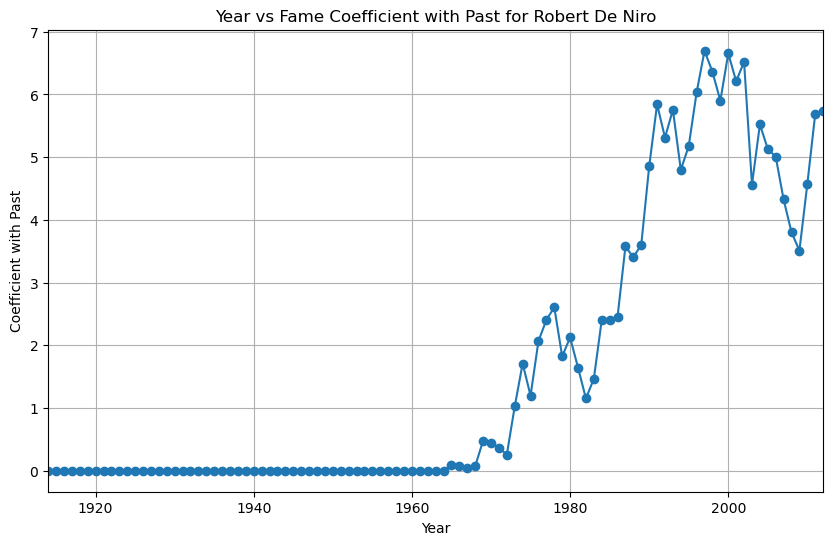

In [108]:
## PLOT FAME OF PARTICULAR ACTOR
actor_name = 'Robert De Niro' #'Steven Spielberg'# # PUT NAME HERE

particular_actor_df = actor_year_df[actor_year_df['Actor Name'] == actor_name]

plt.figure(figsize=(10, 6))
years = particular_actor_df['Year']
coefficients = particular_actor_df['Coefficient with Past']

plt.xlim(1914, 2012)
plt.plot(years, coefficients, marker='o', linestyle='-')
plt.title('Year vs Fame Coefficient with Past for ' + actor_name)
plt.xlabel('Year')
plt.ylabel('Coefficient with Past')
plt.grid(True)

plt.show()

# GENERAL FAME

In [101]:
general_fame = actor_year_df.groupby(['Actor Name'])['Fame Coefficient'].sum().reset_index()
general_fame = general_fame.sort_values(by='Fame Coefficient',ascending=False)
display(general_fame)
# general_fame.head(n=20)

,Actor Name,Fame Coefficient
5216,Mel Blanc,63.889831
6961,Samuel L. Jackson,60.228106
6622,Robert De Niro,52.884473
990,Bruce Willis,49.847447
3796,John Goodman,45.195969
...,...,...
3440,Jayam Ravi,0.290461
4043,Julie Ege,0.259890
5377,Michelle Bauer,0.234955
6454,Rhett Giles,0.063563


# FAME EVOLUTION

In [102]:
# fame_start_end_threshold will be defined
fame_start_end_threshold = 0.2
filtered_actor_year_df = actor_year_df[actor_year_df['Coefficient with Past'] > fame_start_end_threshold]
grouped = filtered_actor_year_df.groupby('Actor Name').agg({'Year': ['min', 'max']})
grouped = grouped.reset_index()
grouped.columns = ['Actor Name', 'First Year', 'Last Year']  # Rename the columns

result_df = grouped.copy()  # Create a copy of grouped DataFrame

result_df['Range'] = result_df['Last Year'] - result_df['First Year']
result_df = result_df.sort_values(by='First Year')
result_df['First Year'] = pd.to_numeric(result_df['First Year'])
result_df['Last Year'] = pd.to_numeric(result_df['Last Year'])
result_df['Range'] = pd.to_numeric(result_df['Range'])


display(result_df)


,Actor Name,First Year,Last Year,Range
8016,Wallace MacDonald,1914,1929,15
2878,Harry von Meter,1914,1927,13
1243,Chester Conklin,1914,1945,31
1219,Charlotte Burton,1914,1919,5
1213,Charlie Chaplin,1914,1976,62
...,...,...,...,...
4670,Livingston,2011,2011,0
562,Asif Ali,2011,2012,1
7935,Vimala Raman,2012,2012,0
4456,Larry Day,2012,2012,0


In [103]:
result_df.head(n=20)

,Actor Name,First Year,Last Year,Range
8016,Wallace MacDonald,1914,1929,15
2878,Harry von Meter,1914,1927,13
1243,Chester Conklin,1914,1945,31
1219,Charlotte Burton,1914,1919,5
1213,Charlie Chaplin,1914,1976,62
1212,Charley Chase,1914,1934,20
5448,Minta Durfee,1914,1967,53
6373,Raymond McKee,1914,1926,12
840,Blanche Sweet,1914,1931,17
5538,Murdock MacQuarrie,1914,1940,26


In [104]:
filtered_actor_year_df = result_df.sort_values(by='First Year')
grouped_years = filtered_actor_year_df.groupby('First Year')['Range'].mean().reset_index()

display(grouped_years)

,First Year,Range
0,1914,26.793103
1,1915,27.500000
2,1916,23.136364
3,1917,28.400000
4,1918,18.571429
...,...,...
94,2008,3.945946
95,2009,2.904762
96,2010,2.000000
97,2011,0.500000


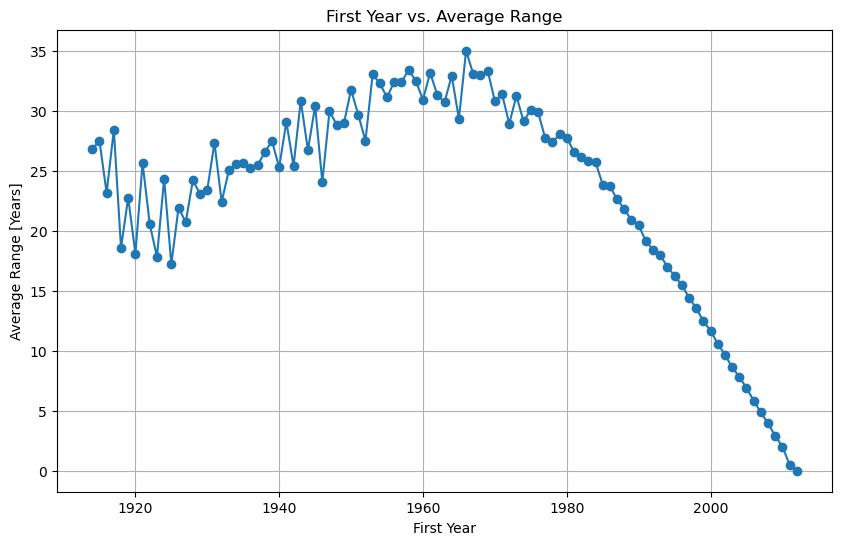

In [105]:
filtered_actor_year_df = result_df.sort_values(by='First Year')
grouped_years = filtered_actor_year_df.groupby('First Year')['Range'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(grouped_years['First Year'], grouped_years['Range'], marker='o', linestyle='-')
plt.title('First Year vs. Average Range')
plt.xlabel('First Year')
plt.ylabel('Average Range [Years]')
plt.grid(True)
plt.show()

# UNUSED BUT MIGHT BE USED

In [106]:
## REMOVED 6TH STEP BUT MIGHT BE USEFUL LATER
## 6TH STEP: REMOVE ACTORS WHO HAVE HAD SUCCESS BEFORE 1924 OR AFTER 2002
## THIS ALLOWS US TO REMOVE ACTORS WHO MIGHT STARTED ACTING BEFORE THE DATASET OR WHO CONTINUED ACTING AFTER
mask = actor_year_df[(actor_year_df['Year'] >= 2002) & (actor_year_df['Coefficient with Past'] > 0.1)]
actors_to_remove = mask['Actor Name'].unique()
filtered_actor_year_df = actor_year_df[~actor_year_df['Actor Name'].isin(actors_to_remove)]

mask = actor_year_df[(actor_year_df['Year'] <= 1924) & (actor_year_df['Coefficient with Past'] > 0.1)]
actors_to_remove = mask['Actor Name'].unique()
filtered_actor_year_df = filtered_actor_year_df[~actor_year_df['Actor Name'].isin(actors_to_remove)]
filtered_actor_year_df.reset_index(drop=True, inplace=True)

display(filtered_actor_year_df)

C:\Users\andre\AppData\Local\Temp\ipykernel_17588\2581459468.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_actor_year_df = filtered_actor_year_df[~actor_year_df['Actor Name'].isin(actors_to_remove)]


,Actor Name,Year,Fame Coefficient,Coefficient with Past
0,Aarti,1914,0.0,0.000000
1,Aarti,1915,0.0,0.000000
2,Aarti,1916,0.0,0.000000
3,Aarti,1917,0.0,0.000000
4,Aarti,1918,0.0,0.000000
...,...,...,...,...
248584,Zero Mostel,2008,0.0,0.000026
248585,Zero Mostel,2009,0.0,0.000018
248586,Zero Mostel,2010,0.0,0.000013
248587,Zero Mostel,2011,0.0,0.000009
